In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras_tuner.tuners import RandomSearch

In [3]:
df = pd.read_csv('diabetes_dataset.csv')
print("Dataset Shape:", df.shape)
display(df.head())
print(df.info())
print(df.describe())

Dataset Shape: (9538, 17)


,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
0,69,5,28.39,130.1,77.0,5.4,130.4,44.0,50.0,90.5,107.9,0.84,0,0,0,1,0
1,32,1,26.49,116.5,72.0,4.5,87.4,54.2,129.9,113.3,81.4,1.39,0,0,0,0,0
2,89,13,25.34,101.0,82.0,4.9,112.5,56.8,177.6,84.7,107.2,0.79,0,0,0,1,0
3,78,13,29.91,146.0,104.0,5.7,50.7,39.1,117.0,108.9,110.0,0.99,0,0,0,1,1
4,38,8,24.56,103.2,74.0,4.7,102.5,29.1,145.9,84.1,92.8,0.91,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9538 entries, 0 to 9537
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 9538 non-null   int64  
 1   Pregnancies         9538 non-null   int64  
 2   BMI                 9538 non-null   float64
 3   Glucose             9538 non-null   float64
 4   BloodPressure       9538 non-null   float64
 5   HbA1c               9538 non-null   float64
 6   LDL                 9538 non-null   float64
 7   HDL                 9538 non-null   float64
 8   Triglycerides       9538 non-null   float64
 9   WaistCircumference  9538 non-null   float64
 10  HipCircumference    9538 non-null   float64
 11  WHR                 9538 non-null   float64
 12  FamilyHistory       9538 non-null   int64  
 13  DietType            9538 non-null   int64  
 14  Hypertension        9538 non-null   int64  
 15  MedicationUse       9538 non-null   int64  
 16  Outcom

In [7]:
categorical_columns = ['FamilyHistory', 'DietType', 'Hypertension', 'MedicationUse']
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])


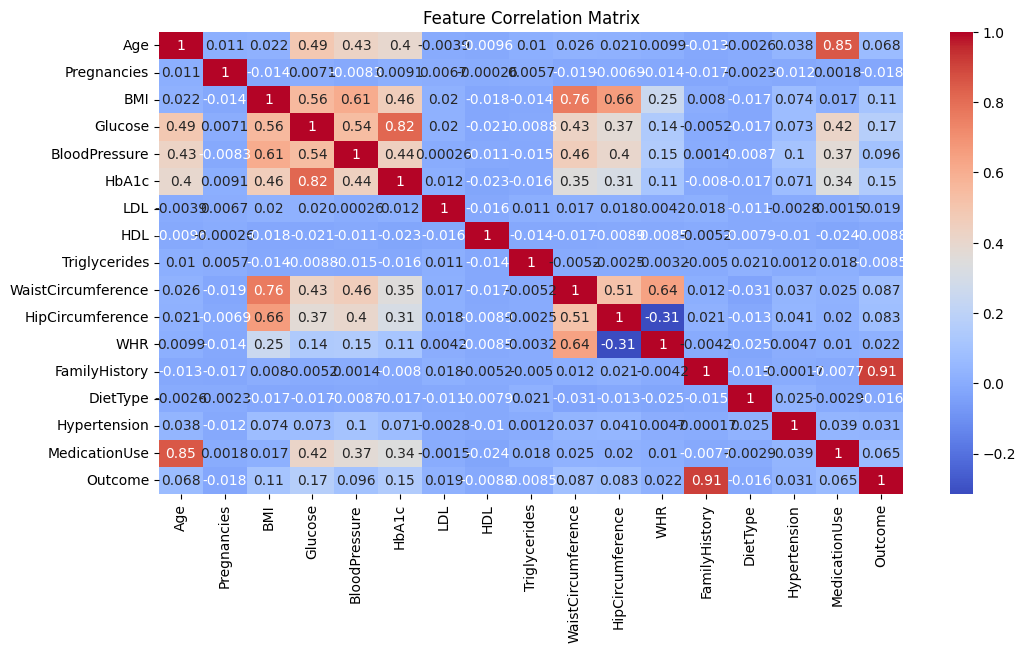

In [8]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

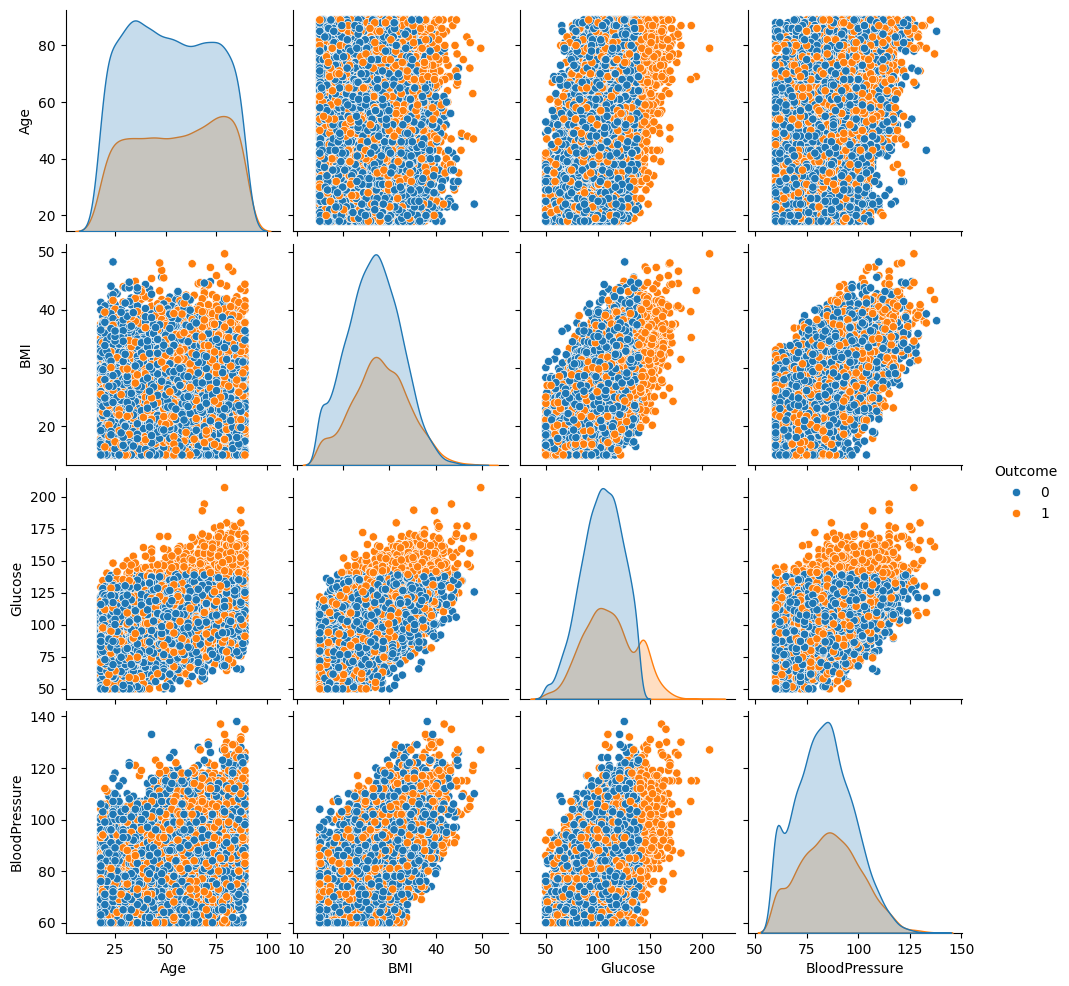

In [9]:
sns.pairplot(df[['Age', 'BMI', 'Glucose', 'BloodPressure', 'Outcome']], hue='Outcome')
plt.show()

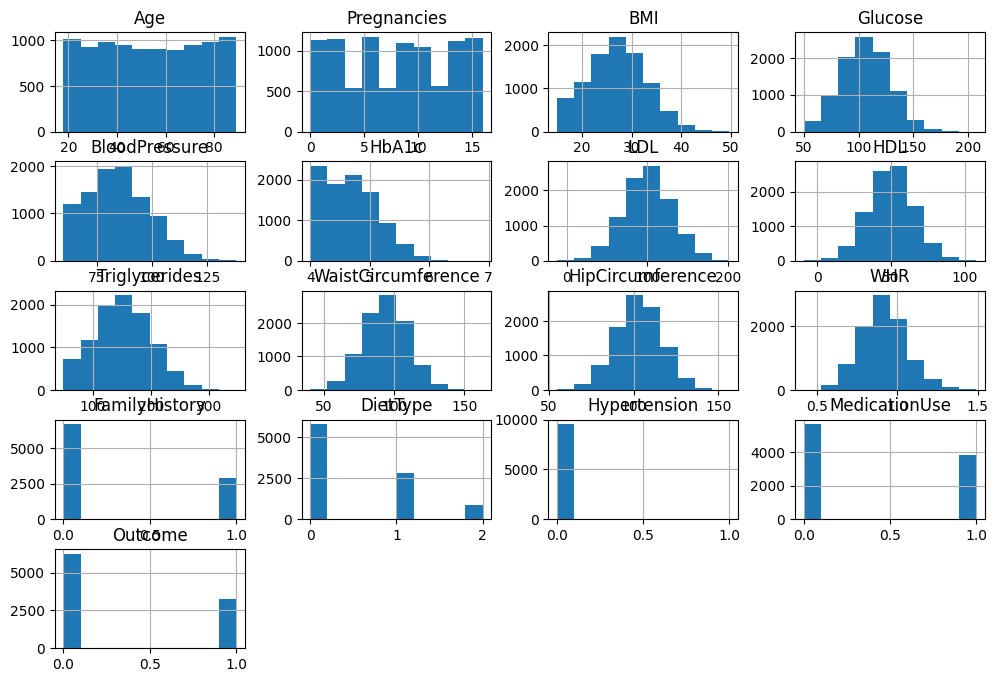

In [10]:
df.hist(figsize=(12, 8))
plt.show()

In [11]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_1', min_value=32, max_value=128, step=16), activation=LeakyReLU(), input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('units_2', min_value=16, max_value=64, step=16), activation=LeakyReLU()))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10, executions_per_trial=2, directory='tuning_results')
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.9905660450458527

Best val_accuracy So Far: 0.9921383857727051
Total elapsed time: 00h 01m 28s


In [14]:
model = build_model(best_hps)


In [17]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)



Epoch 1/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9927 - loss: 0.0198 - val_accuracy: 0.9906 - val_loss: 0.0163
Epoch 2/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9925 - loss: 0.0210 - val_accuracy: 0.9937 - val_loss: 0.0131
Epoch 3/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9917 - loss: 0.0220 - val_accuracy: 0.9953 - val_loss: 0.0119
Epoch 4/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9899 - loss: 0.0319 - val_accuracy: 0.9963 - val_loss: 0.0119
Epoch 5/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9899 - loss: 0.0236 - val_accuracy: 0.9963 - val_loss: 0.0100
Epoch 6/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9936 - loss: 0.0161 - val_accuracy: 0.9958 - val_loss: 0.0104
Epoch 7/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9938 - loss: 0.0155 - val_accuracy: 0.9921 - val_loss: 0.0144
Epoch 8/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9907 - loss: 0.0209 - val_accu

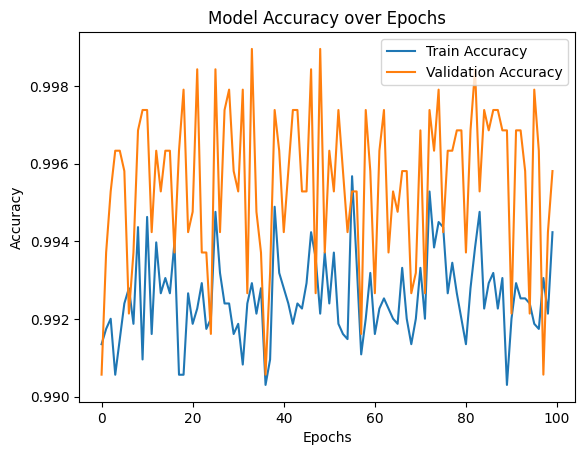

In [18]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Model Accuracy over Epochs")
plt.show()

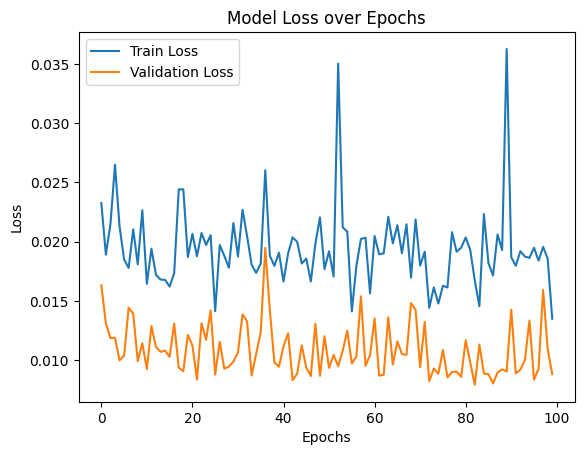

In [19]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Model Loss over Epochs")
plt.show()

In [20]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.9968 - loss: 0.0063
Test Accuracy: 99.58%


In [21]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1275
           1       1.00      0.99      0.99       633

    accuracy                           1.00      1908
   macro avg       1.00      0.99      1.00      1908
weighted avg       1.00      1.00      1.00      1908



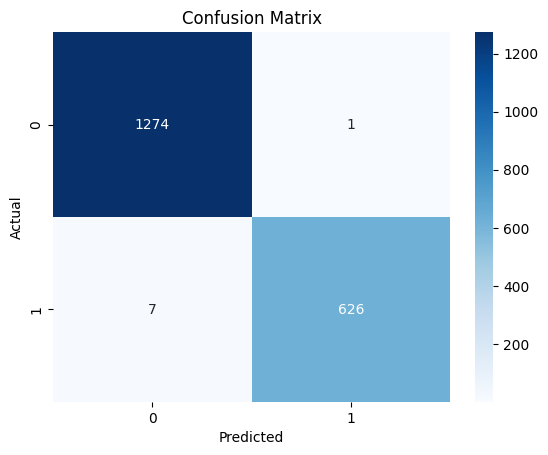

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 1909it [02:04, 14.60it/s]                          


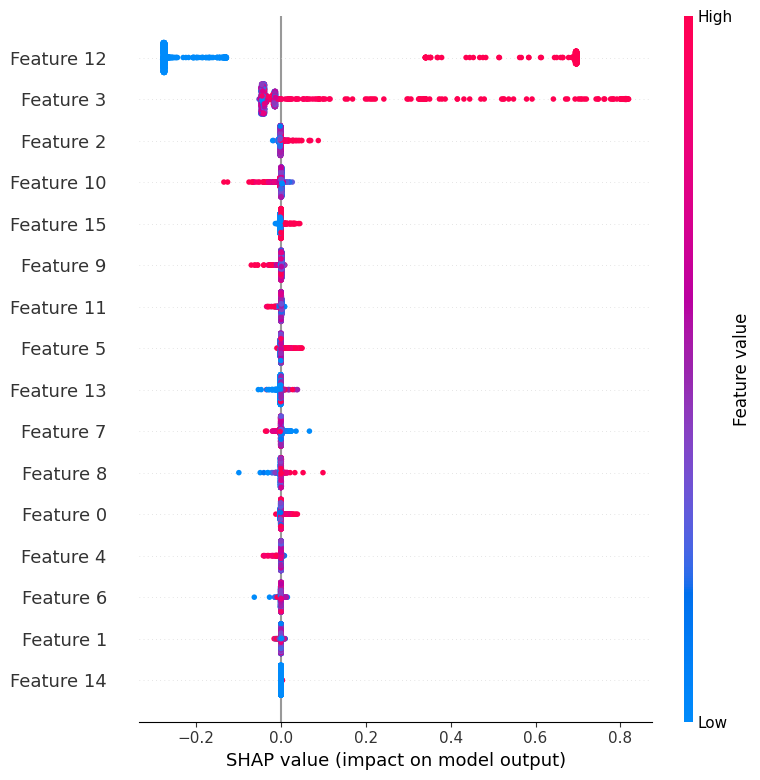

In [25]:
import shap
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [26]:
model.save('optimized_model.h5')